<a href="https://colab.research.google.com/github/offthetab/NN_homework/blob/main/Autoencoder_noise_reduction_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download at first and restart kernel if needed
%%capture
!pip install torchinfo
!pip install torchvision==0.19.0
!pip install pytorch-ignite

In [ ]:
import random
import torch as th
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms.v2 import ToTensor, Compose, GaussianNoise, GaussianBlur
from torchinfo import summary

from ignite.metrics import SSIM, PSNR
from ignite.engine import Engine

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [ ]:
torchvision.__version__

'0.19.0+cu121'

In [ ]:
random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
train_MNIST = datasets.MNIST('./data', download = True, train = True, transform=ToTensor())
test_MNIST = datasets.MNIST('./data', download = True, train = False, transform=ToTensor())

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16176142.53it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 508309.28it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4397480.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5510711.24it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
data, label = train_MNIST[0]
data.dtype, data.shape

(torch.float32, torch.Size([1, 28, 28]))

In [ ]:
# Определим даталоадеры для обучения по батчам
batch_size = 16
train_loader = DataLoader(train_MNIST, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_MNIST, batch_size=batch_size, shuffle=False)

In [ ]:
# torch.Size([32, 1, 28, 28] - 32 картинки, 1 канал изображения, 28 - высота, 28 - ширина
train_batch, train_labels = next(iter(train_loader))
train_batch.shape, train_labels.shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [ ]:
class Autoencoder(th.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = th.nn.Sequential(
            th.nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            th.nn.BatchNorm2d(16),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            th.nn.Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            th.nn.BatchNorm2d(4),
            th.nn.ReLU(),
            th.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
        )
        self.decoder = th.nn.Sequential(
            th.nn.ConvTranspose2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            th.nn.BatchNorm2d(16),
            th.nn.ReLU(),
            th.nn.Upsample(scale_factor=2, mode='bilinear'),
            th.nn.ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            th.nn.BatchNorm2d(16),
            th.nn.Dropout(p=0.15),
            th.nn.ReLU(),
            th.nn.Upsample(scale_factor=2, mode='bilinear'),
            th.nn.ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            th.nn.Sigmoid()
        )

    def forward(self, x, return_embedding=False):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        if return_embedding:
            return encoded, decoded

        return decoded

net = Autoencoder()

In [ ]:
summary(net, input_size=(batch_size, 1, 28, 28), row_settings=["var_names"])

Layer (type (var_name))                  Output Shape              Param #
Autoencoder (Autoencoder)                [16, 1, 28, 28]           --
├─Sequential (encoder)                   [16, 4, 7, 7]             --
│    └─Conv2d (0)                        [16, 16, 28, 28]          160
│    └─BatchNorm2d (1)                   [16, 16, 28, 28]          32
│    └─ReLU (2)                          [16, 16, 28, 28]          --
│    └─MaxPool2d (3)                     [16, 16, 14, 14]          --
│    └─Conv2d (4)                        [16, 4, 14, 14]           580
│    └─BatchNorm2d (5)                   [16, 4, 14, 14]           8
│    └─ReLU (6)                          [16, 4, 14, 14]           --
│    └─MaxPool2d (7)                     [16, 4, 7, 7]             --
├─Sequential (decoder)                   [16, 1, 28, 28]           --
│    └─ConvTranspose2d (0)               [16, 16, 7, 7]            592
│    └─BatchNorm2d (1)                   [16, 16, 7, 7]            32
│    └─ReLU (

In [ ]:
device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')

# перекладываем сеть на GPU
net = net.to(device)

In [ ]:
# функция потерь
loss = th.nn.MSELoss() # Кросс-энтропия
opt = th.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.00001) # #оптимизатор

In [ ]:
num_epochs = 15

noise = Compose([
    GaussianNoise(mean=0.0, sigma=0.4),
])

train_loss_values = []
test_loss_values = []

for epoch in tqdm(range(1, num_epochs+1)):
    train_loss = 0  # Тут будет накопленный лосс на трейновых данных
    for idx, (images, _) in enumerate(train_loader):
        noise_images = noise(images)
        noise_images = noise_images.to(device)

        images = images.to(device) # Отправляем батч на ЦПУ ИЛИ ГПУ

        net.train()
        preds = net.forward(noise_images) # Предикт модели
        loss_value = loss(preds, images) # Вычисление ошибок оптимизатора
        train_loss += loss_value.item()

        # print(f'batch: {idx + 1} // {batch_size * (idx + 1)} images of {len(train_MNIST)} loss: {loss_value}')

        opt.zero_grad() # обнуляем градиент
        loss_value.backward() # обратное распространение ошибки
        opt.step() # шаг оптимизатора

    train_loss /= len(train_loader) # Усредненный лосс функции потерь по батчам на кадой эпохе
    train_loss_values.append(train_loss)

    ### Тестирование модели
    test_loss = 0  # Тут будет накопленный лосс на тестовых данных

    net.eval()
    with th.no_grad():
        for images, _ in test_loader:
            noise_images = noise(images)
            noise_images = noise_images.to(device)

            images = images.to(device) # Отправляем батч на ЦПУ ИЛИ ГПУ

            # test loss
            test_prediction = net.forward(noise_images)
            test_loss_value = loss(test_prediction, images)
            test_loss += test_loss_value.item()

        test_loss /= len(test_loader)   # Усредненный лосс функции потерь по батчам на кадой эпохе
        test_loss_values.append(test_loss)

    print(f'Epoch: {epoch}; Train MSE loss: {train_loss}; Test MSE loss {test_loss};')

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1; Train MSE loss: 0.01772829724053542; Test MSE loss 0.011740429796278477;
Epoch: 2; Train MSE loss: 0.012492935087283453; Test MSE loss 0.011036616796255111;
Epoch: 3; Train MSE loss: 0.01197371883864204; Test MSE loss 0.010450955060124398;
Epoch: 4; Train MSE loss: 0.011735860396673282; Test MSE loss 0.01026402806788683;
Epoch: 5; Train MSE loss: 0.011576737526804208; Test MSE loss 0.01040248293504119;
Epoch: 6; Train MSE loss: 0.011494522014881174; Test MSE loss 0.011018210557848214;
Epoch: 7; Train MSE loss: 0.011412943103164434; Test MSE loss 0.010490176800638438;
Epoch: 8; Train MSE loss: 0.011352797220398982; Test MSE loss 0.010317410095781089;
Epoch: 9; Train MSE loss: 0.011281535014758507; Test MSE loss 0.010677700828760862;
Epoch: 10; Train MSE loss: 0.011267355626324813; Test MSE loss 0.010625774403661489;
Epoch: 11; Train MSE loss: 0.011242604667072494; Test MSE loss 0.010307799407094717;
Epoch: 12; Train MSE loss: 0.011238769950469334; Test MSE loss 0.0114719307467

In [ ]:
# Define the evaluation step
def eval_step(engine, batch):
    net.eval()
    with th.no_grad():
        data, _ = batch
        noised_images = noise(data)
        noised_images = noised_images.to(device)
        data = data.to(device)

        denoised_images = net(noised_images)
        return denoised_images, data

# Create the evaluation engine
engine = Engine(eval_step)

# Create the SSIM metric
ssim_metric = SSIM(data_range=1.0)
ssim_metric.attach(engine, 'ssim')

# Run the evaluation
state = engine.run(test_loader)

# Print the average SSIM
SSIM_value = round(state.metrics["ssim"], 3)
print(f'Average SSIM: {SSIM_value}')

Average SSIM: 0.906


In [ ]:
# Create the PSNR metric
psnr_metric = PSNR(data_range=1.0)
psnr_metric.attach(engine, 'psnr')

# Run the evaluation
state = engine.run(test_loader)

# Print the average PSNR
PSNR_value = round(state.metrics["psnr"], 3)
print(f'Average PSNR: {PSNR_value}')

Average PSNR: 20.367


<Figure size 1600x1200 with 0 Axes>

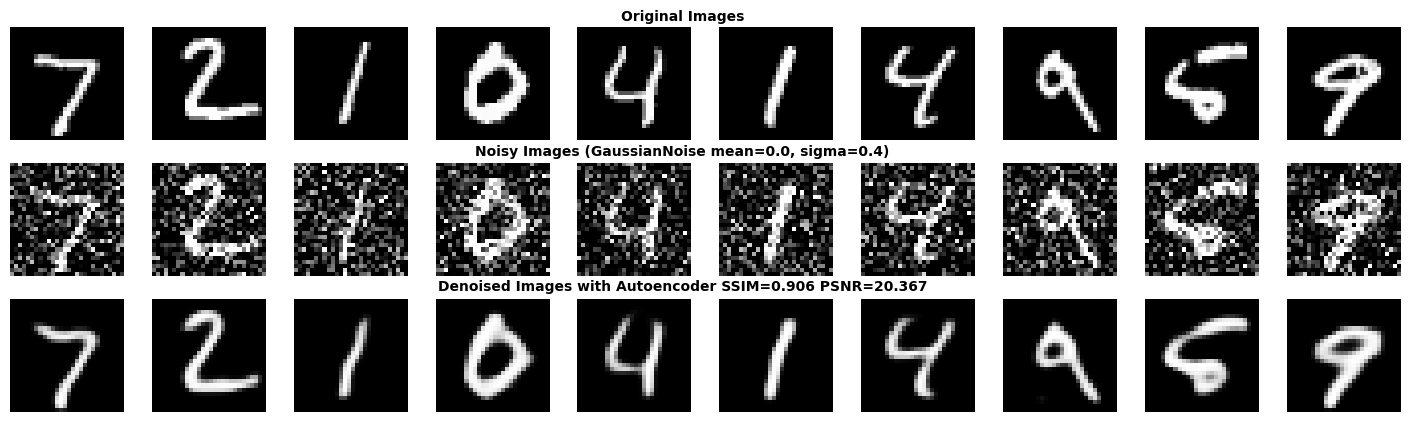

In [ ]:
with th.no_grad():
    for data, _ in test_loader:
        noised_images = noise(data)
        noised_images = noised_images.to(device)
        decoded = net(noised_images)
        break

import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(3, 10, figsize=(18, 5))
for i in range(10):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[1, i].imshow(noised_images[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[2, i].imshow(decoded[i].cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')

fig.text(0.5, 0.9, 'Original Images', ha='center', va='center', fontsize=10, fontweight='bold')
fig.text(0.5, 0.63, 'Noisy Images (GaussianNoise mean=0.0, sigma=0.4)', ha='center', va='center', fontsize=10, fontweight='bold')
fig.text(0.5, 0.36, f'Denoised Images with Autoencoder SSIM={SSIM_value} PSNR={PSNR_value}', ha='center', va='center', fontsize=10, fontweight='bold')

plt.show()

In [ ]:
outputs = []

with th.no_grad():
    for data, _ in test_loader:
        data = noise.forward(data)
        data = data.to(device)
        embedding, decoded = net.forward(data, return_embedding=True)
        outputs.append(th.reshape(embedding.cpu(), (16, 4*7*7)))

embeddings = th.cat(outputs, dim=0)
embeddings.shape

torch.Size([10000, 196])

In [ ]:
embeddings_2d = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=40).fit_transform(embeddings)
embeddings_2d.shape

(10000, 2)

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


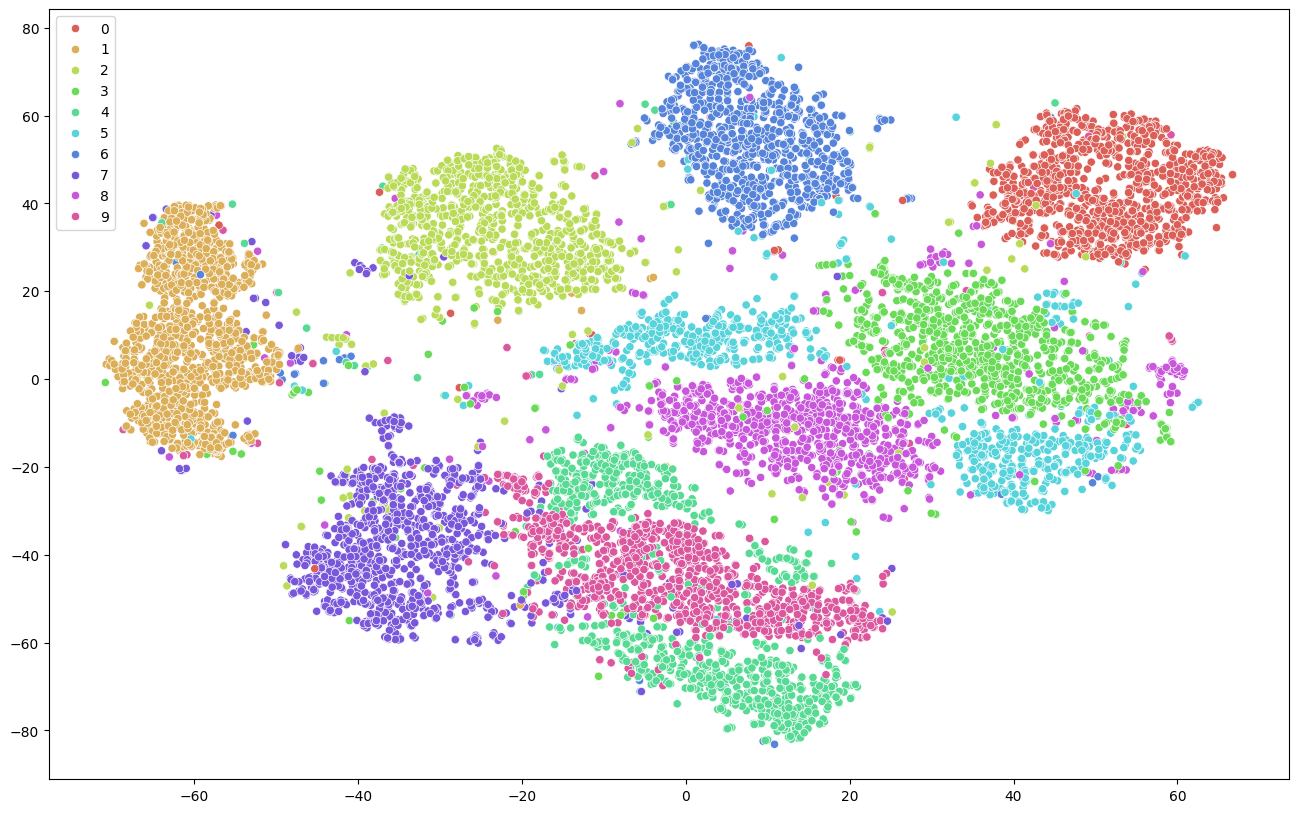

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x=embeddings_2d[:, 0],
                y=embeddings_2d[:, 1],
                hue=test_MNIST.test_labels.tolist(),
                palette=sns.color_palette("hls", 10))
plt.show()